# Alerts analysis from Cumta (Red Alerts in Israel) channel (end of 2018 - end of 2025)

#### Over 26,000 rockets, missiles, and drones have been fired toward Israel from multiple fronts since 7 Oct 2023.
* 13,200 from Gaza
* 12,400 from Lebanon (Hezbollah)
* 400 from Iran (direct / indirect)
* 180 from Yemen (Houthis)
* 60 from Syria

In [83]:
import numpy as np
import pandas as pd
import sqlite3
import re
import csv
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import json
import plotly.graph_objects as go
from scipy.stats import chisquare

# %pip install nbformat

In [84]:
pio.renderers.default = "notebook_connected"
pd.options.display.float_format = "{:,.2f}".format

In [85]:
conn = sqlite3.connect("cumta_alerts.db")
query = "SELECT * FROM alerts"
df = pd.read_sql_query(query, conn)
conn.close()
print(df.head())

   id       alert_datetime alert_type alert_zone               locality  \
0   1  2018-12-26 08:05:08  Red Alert        Dan  Tel Aviv (South West)   
1   2  2018-12-26 08:05:08  Red Alert        Dan       Tel Aviv (North)   
2   3  2018-12-26 08:05:08  Red Alert        Dan     Tel Aviv (Central)   
3   4  2018-12-26 08:05:08  Red Alert        Dan  Tel Aviv (South East)   
4   5  2018-12-26 08:05:08  Red Alert        Dan                   Azur   

     region  raw_message_id           city  
0  Tel Aviv              42  Tel Aviv-Yafo  
1  Tel Aviv              42  Tel Aviv-Yafo  
2  Tel Aviv              42  Tel Aviv-Yafo  
3  Tel Aviv              42  Tel Aviv-Yafo  
4  Tel Aviv              42           Azur  


## Data / dataset exploration

In [86]:
df.shape
df.columns

Index(['id', 'alert_datetime', 'alert_type', 'alert_zone', 'locality',
       'region', 'raw_message_id', 'city'],
      dtype='object')

In [87]:
df.duplicated().sum() # 0

np.int64(0)

In [88]:
df.isna().values.any() # true
a = df[df.isna().any(axis=1)]
a.alert_zone.value_counts()
df.drop(a.index, inplace=True)
df.isna().values.any() # False

np.False_

## Descriptive stats

In [89]:
df["alert_datetime"] = pd.to_datetime(df["alert_datetime"], errors="coerce")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100304 entries, 0 to 100324
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              100304 non-null  int64         
 1   alert_datetime  100304 non-null  datetime64[ns]
 2   alert_type      100304 non-null  object        
 3   alert_zone      100304 non-null  object        
 4   locality        100304 non-null  object        
 5   region          100304 non-null  object        
 6   raw_message_id  100304 non-null  int64         
 7   city            100304 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 6.9+ MB


In [90]:
df.describe() # no numeric values in df

,id,alert_datetime,raw_message_id
count,"100,304.00",100304,"100,304.00"
mean,"50,164.69",2024-08-16 21:00:04.060874752,"30,928.46"
min,1.00,2018-12-26 08:05:08,42.00
25%,"25,077.75",2024-05-17 15:01:15.500000,"21,228.00"
50%,"50,168.50",2024-11-24 15:34:49,"38,162.00"
75%,"75,246.25",2025-06-16 04:11:16,"41,226.00"
max,"100,325.00",2026-01-02 10:02:40,"44,171.00"
std,"28,961.96",NaN,"12,822.91"


## Alerts per region

In [91]:
alert_regions_count = df.region.value_counts().reset_index()
alert_regions_count.columns = ["alert_region", "count"]
# alert_regions_count = alert_regions_count.dropna(subset=["region"])
alert_regions_count = alert_regions_count.sort_values(by="count", ascending=False)
alert_regions_count

,alert_region,count
0,North,34227
1,Center,30554
2,South,18834
3,Yosh,6076
4,Jerusalem,3940
5,Haifa,3387
6,Tel Aviv,3286


In [139]:
import os

region_share_graph = px.pie(
    alert_regions_count,
    names="alert_region",
    values="count",
    title="Region share",
    hole=0.6,
    color_discrete_sequence=px.colors.qualitative.Set3,
)
region_share_graph.update_traces(textposition="outside", textinfo="percent+label")

# Save static image
region_share_graph.write_image(
    os.path.join("temp_imgs", "fig1.png")
)  # This is required

In [93]:
region_share_graph = px.pie(
    alert_regions_count,
    names="alert_region",
    values="count",
    title="Region share",
    hole=0.6,
    color_discrete_sequence=px.colors.qualitative.Set3,
)
region_share_graph.update_traces(textposition="outside", textinfo="percent+label")
region_share_graph.show()

## Alerts per zone

In [94]:
alert_zones_count = df.alert_zone.value_counts().reset_index()
alert_zones_count.columns = ["alert_zone", "count"]
alert_zones_count = alert_zones_count.sort_values(by="count", ascending=False)
alert_zones_count

,alert_zone,count
0,Confrontation Line,14966
1,Lakhish,9725
2,HaShfela,8914
3,Sharon,7434
4,Upper Galilee,6865
...,...,...
60,מיני ישראל,1
61,יהוד מונוסון,1
62,שוהם,1
63,Nili,1


In [95]:
alert_zones_count.sort_index()
# alert_zones_count.to_csv(
#     "alert_zone_cleaned.csv", index=False, quoting=csv.QUOTE_NONE, escapechar="\\"
# )


,alert_zone,count
0,Confrontation Line,14966
1,Lakhish,9725
2,HaShfela,8914
3,Sharon,7434
4,Upper Galilee,6865
...,...,...
60,מיני ישראל,1
61,יהוד מונוסון,1
62,שוהם,1
63,Nili,1


In [96]:
zones_graph = px.bar(
    alert_zones_count[:35],
    x="count",
    y="alert_zone",
    orientation="h",
    title="Alerts by the zone",
    text="count",
)

zones_graph.update_layout(
    height=1200,
    yaxis_title="Zone",
    xaxis_title="Alerts count",
    yaxis=dict(categoryorder="total ascending"),
)

zones_graph.show()

In [97]:
df_confline = df[df['alert_zone'] == "Confrontation Line"]
count_cl = df_confline.region.value_counts()
count_cl
# region
# North     14275
# South       475
# Center      215

region
North     14276
South       475
Center      215
Name: count, dtype: int64

As seen above, Confrontation Line is NOT some specific zone or location, it mostly refers to the area closest to the active war operation zone. Out of 14965 alerts in Confrontation Line, 14275 of them came in at the North.

In [98]:
# # below cell code DOES NOT work! saving it here in case choropleth introduces updates taht will enable to run it.
# # Why? Choropleth maps DO NOT work with Point geometries. Plotly expects: Polygon or MultiPolygon. 
# # However to use polygon i need proper regional boundaries which i won't find online.
# # Therefore am using a workaround and plotting a scatter graph on a picture of a map in a cell under this one.

# # loading my GeoJSON
# with open("alert_zones.geojson", "r", encoding="utf-8") as f:
#     geojson_data = json.load(f)

# # ensuring alert_zone names match exactly
# alert_zones_count["alert_zone"] = alert_zones_count["alert_zone"].str.strip()

# map_by_zone = px.choropleth_map(
#     alert_zones_count,
#     geojson=geojson_data,
#     locations="alert_zone",
#     featureidkey="properties.alert_zone",
#     color="count",
#     color_continuous_scale="Viridis",
#     map_style="carto-positron",
#     zoom=6,
#     center={"lat": 31.8, "lon": 35.0},
#     opacity=0.6,
# )

# map_by_zone.update_layout(margin=dict(l=0, r=0, t=0, b=0))
# map_by_zone.show()

In [99]:
with open("alert_zones.geojson", "r", encoding="utf-8") as f:
    geojson_data = json.load(f)
features = geojson_data["features"]

coords = []
for f in features:
    coords.append(
        {
            "alert_zone": f["properties"]["alert_zone"],
            "lon": f["geometry"]["coordinates"][0],
            "lat": f["geometry"]["coordinates"][1],
        }
    )

zones_coords = pd.DataFrame(coords)
zones_coords.head()

,alert_zone,lon,lat
0,Arabah,35.00,30.50
1,Arava,35.00,30.80
2,Ashdod,34.64,31.80
3,Beit She'an Valley,35.50,32.50
4,Beit Shemesh,34.99,31.73


In [100]:
zones_map_df = alert_zones_count.merge(zones_coords, on="alert_zone", how="inner")
zones_map_df

,alert_zone,count,lon,lat
0,Confrontation Line,14966,35.00,31.50
1,Lakhish,9725,34.80,31.50
2,HaShfela,8914,34.80,31.80
3,Sharon,7434,34.87,32.18
4,Upper Galilee,6865,35.30,33.00
...,...,...,...,...
60,מיני ישראל,1,32.10,34.95
61,יהוד מונוסון,1,32.20,34.90
62,שוהם,1,31.90,35.00
63,Nili,1,31.75,35.00


In [101]:
fig = px.scatter_map(
    zones_map_df,
    lat="lat",
    lon="lon",
    size="count",
    color="count",
    color_continuous_scale="Viridis",
    size_max=40,
    zoom=6,
    center={"lat": 31.8, "lon": 35.0},
    map_style="carto-positron",
    hover_name="alert_zone",
)

fig.show()

## Alerts per city

In [102]:
alert_city_count = df.city.value_counts().reset_index()
alert_city_count.columns = ["alert_city", "count"]
alert_city_count = alert_city_count.sort_values(by="count", ascending=False)
alert_city_count

,alert_city,count
0,Ashdod,2585
1,Ashkelon,1041
2,Nir Am,731
3,Tel Aviv-Yafo,622
4,Kiryat Shmona,595
...,...,...
1495,Neveh Haim,1
1496,Yearot HaCarmel,1
1497,North,1
1498,South,1


Reading above result must be careful! The cities like 'Ashdod', "Herzliyya' and 'Tel Aviv' include variety of its districts and nearby localities / industrial zones. Sq space of Ashdod city as per dataset is much larger than Kiryat Shmona, the alerts are sounded in separate districts of large city. However smaller cities liek Kiryat Shmona have alert sounded all over the city. Another example is Nativ haAssara, very close to Gaza border. It's a very small town, however it was constantly shelled during certain periods of war. It's alerts count is comparable to Herzliyaa alerts. However Herzliyya has been shelled from all sides: north, south and east (Lebanon, Iran, Yemen). While shelling in Nativ haAssara is 99% hands of shelling from Gaza.

In [103]:
# top 50 cities by count of alerts
top50 = alert_city_count.head(50)

top50_cities_graph = px.bar(
    top50,
    x="count",
    y="alert_city",
    orientation="h",
    title="Alerts by the city",
    text="count",
)

top50_cities_graph.update_layout(
    height=1200,
    yaxis_title="City",
    xaxis_title="Alerts count",
    yaxis=dict(autorange="reversed"),
)

top50_cities_graph.show()

## Calendar detalization & analysis

In [104]:
df["alert_date"] = df["alert_datetime"].dt.floor("D")
df["alert_time"] = pd.to_datetime(
    df["alert_datetime"].dt.strftime("%H:%M:%S"),
    format="%H:%M:%S",
)
df.head(200)

,id,alert_datetime,alert_type,alert_zone,locality,region,raw_message_id,city,alert_date,alert_time
0,1,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (South West),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08
1,2,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (North),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08
2,3,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (Central),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08
3,4,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (South East),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08
4,5,2018-12-26 08:05:08,Red Alert,Dan,Azur,Tel Aviv,42,Azur,2018-12-26,1900-01-01 08:05:08
...,...,...,...,...,...,...,...,...,...,...
195,196,2019-03-15 04:08:40,Red Alert,Gaza Containment,Sapir Academy,South,80,Sapir,2019-03-15,1900-01-01 04:08:40
196,197,2019-03-15 04:08:40,Red Alert,Gaza Containment,Nir Am,South,80,Nir Am,2019-03-15,1900-01-01 04:08:40
197,198,2019-03-15 04:08:40,Red Alert,Gaza Containment,Sapirim Industrial Park,South,80,Sapirim Industrial Park,2019-03-15,1900-01-01 04:08:40
198,199,2019-03-15 04:08:40,Red Alert,Gaza Containment,Sderot,South,80,Sderot,2019-03-15,1900-01-01 04:08:40


In [105]:
df["month_year"] = df["alert_datetime"].dt.to_period("M")
df.head()
# df.info()
## 8   alert_date      5 non-null       datetime64[ns]
## 9   alert_time      5 non-null       datetime64[ns]
## 10  month_year      5 non-null       period[M]   

,id,alert_datetime,alert_type,alert_zone,locality,region,raw_message_id,city,alert_date,alert_time,month_year
0,1,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (South West),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12
1,2,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (North),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12
2,3,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (Central),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12
3,4,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (South East),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12
4,5,2018-12-26 08:05:08,Red Alert,Dan,Azur,Tel Aviv,42,Azur,2018-12-26,1900-01-01 08:05:08,2018-12


In [106]:
# number of alerts by city and date
by_city_day = df.groupby(["city", "alert_date"]).size().reset_index(name="count")
# top 25 worst days and where they happened
top25_days = by_city_day.sort_values(by="count", ascending=False).head(25)
top25_days

,city,alert_date,count
2374,Ashdod,2023-10-07,389
2367,Ashdod,2019-11-13,311
2473,Ashkelon,2023-10-07,218
2415,Ashdod,2025-06-13,189
2366,Ashdod,2019-11-12,113
31012,Netiv HaAssara,2023-10-07,94
2416,Ashdod,2025-06-14,85
2422,Ashdod,2025-06-22,84
2417,Ashdod,2025-06-15,84
4329,Beersheba,2023-10-07,76


In [107]:
top25_days_graph = px.scatter(
    top25_days,
    x="alert_date",
    y="count",
    color="city",
    size="count",
    hover_data={"city": True, "alert_date": True, "count": True},
    title="25 worst days by city",
)

top25_days_graph.update_layout(
    xaxis=dict(tickformat="%b %d %Y"),
    yaxis_title="Number of alerts",
    height=800,
)

top25_days_graph.show()

In [108]:
# time of the day
# this code cell takes long time to run, even 3 min+

def classify_period(t):
    if pd.isna(t):
        return None

    # Convert Timestamp → time
    if isinstance(t, pd.Timestamp):
        t = t.time()

    if t >= pd.to_datetime("22:00:00").time() or t < pd.to_datetime("06:00:00").time():
        return "night"
    elif t >= pd.to_datetime("06:00:00").time() and t < pd.to_datetime("12:00:00").time():
        return "morning"
    elif t >= pd.to_datetime("12:00:00").time() and t < pd.to_datetime("18:00:00").time():
        return "afternoon"
    else:
        return "evening"


df["period"] = df["alert_time"].apply(classify_period)

df[["alert_datetime", "alert_time", "period"]].head()

,alert_datetime,alert_time,period
0,2018-12-26 08:05:08,1900-01-01 08:05:08,morning
1,2018-12-26 08:05:08,1900-01-01 08:05:08,morning
2,2018-12-26 08:05:08,1900-01-01 08:05:08,morning
3,2018-12-26 08:05:08,1900-01-01 08:05:08,morning
4,2018-12-26 08:05:08,1900-01-01 08:05:08,morning


In [109]:
# by_period = df.period.value_counts().reset_index(name='count')
# by_period = by_period.sort_values(by="count", ascending=False)
by_period = df.period.value_counts()
by_period

period
morning      28459
evening      26619
night        23308
afternoon    21918
Name: count, dtype: int64

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100304 entries, 0 to 100324
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              100304 non-null  int64         
 1   alert_datetime  100304 non-null  datetime64[ns]
 2   alert_type      100304 non-null  object        
 3   alert_zone      100304 non-null  object        
 4   locality        100304 non-null  object        
 5   region          100304 non-null  object        
 6   raw_message_id  100304 non-null  int64         
 7   city            100304 non-null  object        
 8   alert_date      100304 non-null  datetime64[ns]
 9   alert_time      100304 non-null  datetime64[ns]
 10  month_year      100304 non-null  period[M]     
 11  period          100304 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(6), period[M](1)
memory usage: 9.9+ MB


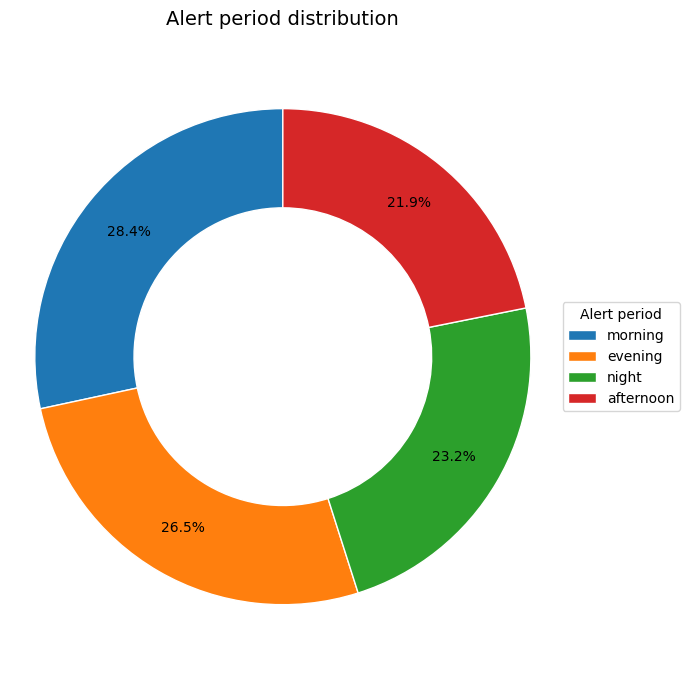

In [111]:
labels = by_period.index
sizes = by_period.values


def autopct_threshold(threshold=2):  # do not display label if value < 2%
    def autopct(pct):
        return f"{pct:.1f}%" if pct >= threshold else ""

    return autopct


fig, ax = plt.subplots(figsize=(7, 7))

wedges, texts, autotexts = ax.pie(
    sizes,
    startangle=90,
    autopct=autopct_threshold(2),
    pctdistance=0.8,
    wedgeprops={"width": 0.4, "edgecolor": "white"},
)

ax.set_title("Alert period distribution", fontsize=14)
ax.axis("equal")

ax.legend(
    wedges, labels, title="Alert period", loc="center left", bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()

In [112]:
by_period_region = (
    df.dropna(subset=["period", "region"])
    .groupby(["period", "region"])
    .size()
    .reset_index(name="count")
)
by_period_region = by_period_region.sort_values(["period", "count"], ascending=[True, False])
by_period_region

,period,region,count
3,afternoon,North,10396
0,afternoon,Center,4690
4,afternoon,South,4468
1,afternoon,Haifa,802
5,afternoon,Tel Aviv,622
6,afternoon,Yosh,542
2,afternoon,Jerusalem,398
7,evening,Center,9170
10,evening,North,6305
11,evening,South,5570


In [113]:
period_region_graph = px.treemap(
    by_period_region,
    path=["period", "region"],
    values="count",
    color='period',
    title="Alerts period by region",
)
period_region_graph.update_traces(
    hovertemplate="<b>%{label}</b><br>Alerts: %{value}<extra></extra>"
)  # %{label} and %{value} are Plotly hover placeholders, nice tooltip
period_region_graph.show()

### Who suffered from most night alerts?

In [114]:
df_night = df[df['period'] == 'night']
df_night.head()
night_city_count = df_night.city.value_counts().reset_index(name='count')
night_city_count = night_city_count.sort_values(by="count", ascending=False)
top_n = 20
night_city_count = night_city_count.head(top_n)
night_city_count["share"] = (
    night_city_count["count"] / night_city_count["count"].sum() * 100)
night_city_count
# share shown within all 20 cities total, not share of night alerts within each city total alerts

,city,count,share
0,Ashdod,277,13.51
1,Tel Aviv-Yafo,197,9.61
2,Herzliyya,146,7.12
3,Ashkelon,137,6.68
4,Rishon LeZiyyon,117,5.70
5,Ben Shemen,112,5.46
6,Nir Am,110,5.36
7,Ramat Gan,105,5.12
8,Ramla,100,4.88
9,Haifa,81,3.95


In [115]:
night_alerts_graph = px.funnel(
    night_city_count,
    x="count",
    y="city",
    text=night_city_count["share"].round(1).astype(str) + "%",
    title="Cities with the Most Night Alerts",
)

night_alerts_graph.update_traces(
    texttemplate="%{text} • %{value:,} alerts",
    textposition="auto",
    textfont=dict(
        size=18,
        color="white",
    ),
)

night_alerts_graph.update_layout(
    height=650,
    yaxis=dict(categoryorder="total descending"),
    uniformtext_minsize=16,
)

night_alerts_graph.show()

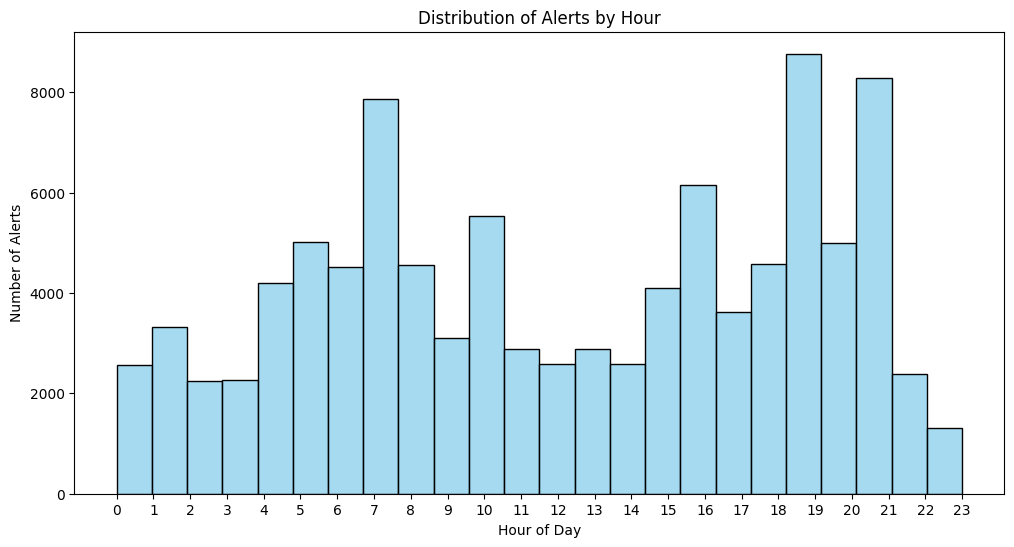

In [116]:
plt.figure(figsize=(12, 6))
sns.histplot(df["alert_datetime"].dt.hour, bins=24, kde=False, color="skyblue")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Alerts")
plt.title("Distribution of Alerts by Hour")
plt.xticks(range(0, 24))
plt.show()

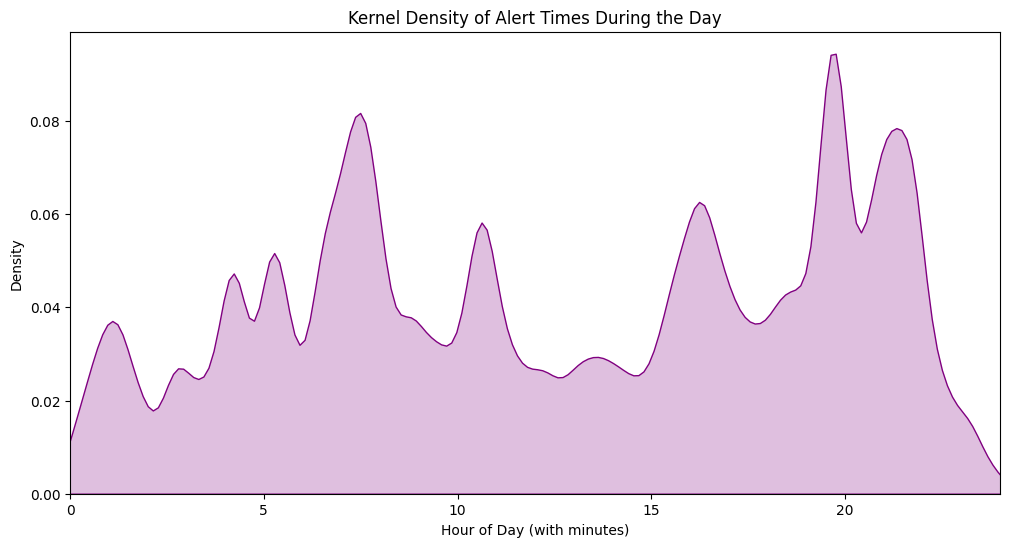

In [117]:
plt.figure(figsize=(12, 6))
alert_times_in_hours = (
    df["alert_datetime"].dt.hour + df["alert_datetime"].dt.minute / 60
)
sns.kdeplot(alert_times_in_hours, bw_adjust=0.5, fill=True, color="purple")
plt.xlabel("Hour of Day (with minutes)")
plt.ylabel("Density")
plt.title("Kernel Density of Alert Times During the Day")
plt.xlim(0, 24)
plt.show()

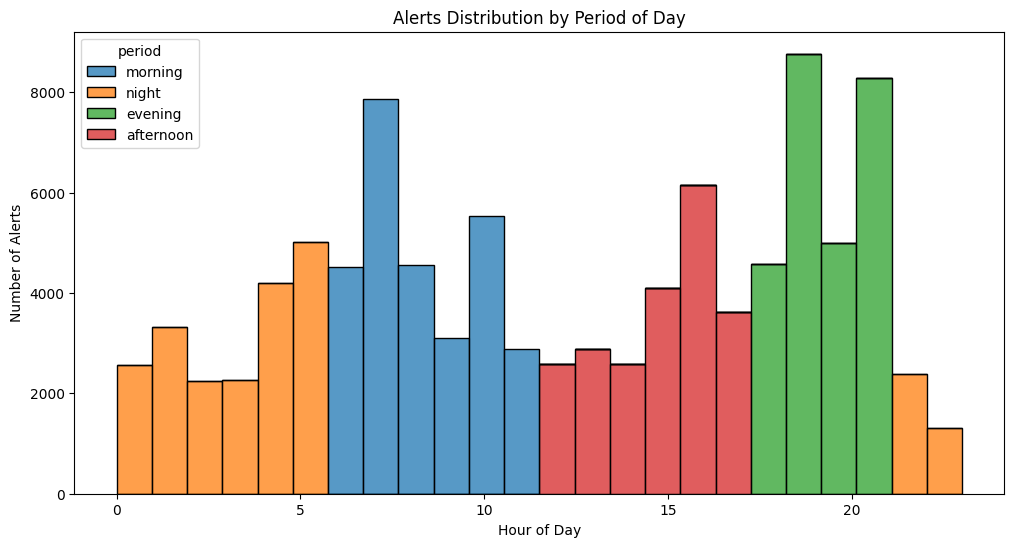

In [118]:
plt.figure(figsize=(12, 6))
sns.histplot(
    df, x=df["alert_datetime"].dt.hour, hue="period", multiple="stack", bins=24
)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Alerts")
plt.title("Alerts Distribution by Period of Day")
plt.show()

## Timeline

In [119]:
by_month_year = df.groupby("month_year").size().reset_index(name="count")
by_month_year = by_month_year.sort_values("month_year")
by_month_year["month_year"] = by_month_year["month_year"].dt.to_timestamp()
by_month_year

,month_year,count
0,2018-12-01,60
1,2019-01-01,32
2,2019-02-01,35
3,2019-03-01,327
4,2019-04-01,1
...,...,...
70,2025-09-01,1987
71,2025-10-01,239
72,2025-11-01,8
73,2025-12-01,5


In [120]:
by_month_year_graph = px.line(
    by_month_year,
    x="month_year",
    y="count",
    markers=True,
    title="Alerts per Month",
    labels={
        "month_year": "Year & Month",
        "count": "Alerts count",
    },
)

by_month_year_graph.update_traces(
    hovertemplate="Month: %{x|%Y-%m}<br>Alerts: %{y:,}<extra></extra>"
)

by_month_year_graph.update_layout(height=500, xaxis=dict(tickformat="%Y-%m"))

by_month_year_graph.show()

In [121]:
df.head()

,id,alert_datetime,alert_type,alert_zone,locality,region,raw_message_id,city,alert_date,alert_time,month_year,period
0,1,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (South West),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning
1,2,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (North),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning
2,3,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (Central),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning
3,4,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (South East),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning
4,5,2018-12-26 08:05:08,Red Alert,Dan,Azur,Tel Aviv,42,Azur,2018-12-26,1900-01-01 08:05:08,2018-12,morning


In [122]:
df["year_clean"] = df["alert_datetime"].dt.year

df_7years = df[(df["year_clean"] >= 2019) & (df["year_clean"] <= 2025)]

by_year_period = (
    df_7years.groupby(["year_clean", "period"]).size().reset_index(name="count")
)
by_year_period["share"] = by_year_period["count"] / by_year_period.groupby(
    "year_clean"
)["count"].transform("sum")

by_year_period = by_year_period.sort_values(by="year_clean")

period_change_graph = px.bar(
    by_year_period,
    x="share",
    y="year_clean",
    color="period",
    orientation="h",
    title="Share of alerts by period per year (2019–2025)",
    labels={
        "year_clean": "Year",
        "share": "Share of alerts",
        "period": "Period of day",
    },
    color_discrete_map={
        "night": "darkorchid",
        "morning": "mediumseagreen",
        "afternoon": "gold",
        "evening": "darkgrey",
    },
)
period_change_graph.update_traces(
    hovertemplate=(
        "Year: %{x}<br>" "Period: %{legendgroup}<br>" "Share: %{y:.1%}<extra></extra>"
    )
)
period_change_graph.show()

In [123]:
region_alert_type = (
    df.groupby(["region", "alert_type"]).size().reset_index(name="count")
)
region_alert_type["share"] = region_alert_type["count"] / region_alert_type.groupby(
    "region"
)["count"].transform("sum")

region_alert_type_graph = px.bar(
    region_alert_type,
    x="share",
    y="region",
    color="alert_type",
    orientation="h",
    title="Share of alerts by type per region",
    labels={
        "region": "Region",
        "share": "Share of alerts",
        "alert_type": "Type",
    },
    color_discrete_map={
        "night": "darkorchid",
        "morning": "mediumseagreen",
        "afternoon": "gold",
        "evening": "darkgrey",
    },
)
region_alert_type_graph.update_traces(
    hovertemplate=(
        "Region: %{x}<br>"
        "Alert type: %{legendgroup}<br>"
        "Share: %{y:.1%}<extra></extra>"
    )
)

region_alert_type_graph.show()

In [124]:
# minute of the hour
def classify_minute_bucket(t):
    if pd.isna(t):
        return None

    # if Timestamp -> extract minute
    if isinstance(t, pd.Timestamp):
        minute = t.minute
    else:
        minute = t.minute  # datetime.time also has .minute

    if minute <= 5 or minute >= 55:
        return "00-minute"
    elif 25 <= minute <= 35:
        return "30-minute"
    else:
        return "other"

df["minute_bucket"] = df["alert_time"].apply(classify_minute_bucket)
df.head()

,id,alert_datetime,alert_type,alert_zone,locality,region,raw_message_id,city,alert_date,alert_time,month_year,period,year_clean,minute_bucket
0,1,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (South West),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning,2018,00-minute
1,2,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (North),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning,2018,00-minute
2,3,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (Central),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning,2018,00-minute
3,4,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (South East),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning,2018,00-minute
4,5,2018-12-26 08:05:08,Red Alert,Dan,Azur,Tel Aviv,42,Azur,2018-12-26,1900-01-01 08:05:08,2018-12,morning,2018,00-minute


In [125]:
by_region_minute = (
    df.groupby(["region", "minute_bucket"]).size().reset_index(name="count")
)

by_region_minute["share"] = by_region_minute["count"] / by_region_minute.groupby(
    "region")["count"].transform("sum")
by_region_minute

,region,minute_bucket,count,share
0,Center,00-minute,4622,0.15
1,Center,30-minute,4463,0.15
2,Center,other,21469,0.70
3,Haifa,00-minute,525,0.16
4,Haifa,30-minute,571,0.17
5,Haifa,other,2291,0.68
6,Jerusalem,00-minute,591,0.15
7,Jerusalem,30-minute,799,0.20
8,Jerusalem,other,2550,0.65
9,North,00-minute,5981,0.17


In [126]:
df.head()

,id,alert_datetime,alert_type,alert_zone,locality,region,raw_message_id,city,alert_date,alert_time,month_year,period,year_clean,minute_bucket
0,1,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (South West),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning,2018,00-minute
1,2,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (North),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning,2018,00-minute
2,3,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (Central),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning,2018,00-minute
3,4,2018-12-26 08:05:08,Red Alert,Dan,Tel Aviv (South East),Tel Aviv,42,Tel Aviv-Yafo,2018-12-26,1900-01-01 08:05:08,2018-12,morning,2018,00-minute
4,5,2018-12-26 08:05:08,Red Alert,Dan,Azur,Tel Aviv,42,Azur,2018-12-26,1900-01-01 08:05:08,2018-12,morning,2018,00-minute


In [127]:
by_year_minute = (
    df.groupby(["year_clean", "minute_bucket"]).size().reset_index(name="count")
)

by_year_minute["share"] = by_year_minute["count"] / by_year_minute.groupby(
    "year_clean"
)["count"].transform("sum")
by_year_minute

,year_clean,minute_bucket,count,share
0,2018,00-minute,60,1.00
1,2019,00-minute,1047,0.22
2,2019,30-minute,428,0.09
3,2019,other,3242,0.69
4,2020,00-minute,56,0.17
5,2020,30-minute,44,0.14
6,2020,other,224,0.69
7,2021,00-minute,16,0.14
8,2021,30-minute,26,0.23
9,2021,other,71,0.63


In [128]:
plot_df = by_region_minute.pivot(
    index="region", columns="minute_bucket", values="share"
).fillna(0)
plot_df = plot_df[["00-minute", "30-minute", "other"]]

plot_df

minute_bucket,00-minute,30-minute,other
region,,,
Center,0.15,0.15,0.70
Haifa,0.16,0.17,0.68
Jerusalem,0.15,0.20,0.65
North,0.17,0.16,0.67
South,0.21,0.16,0.63
Tel Aviv,0.21,0.15,0.64
Yosh,0.07,0.14,0.79


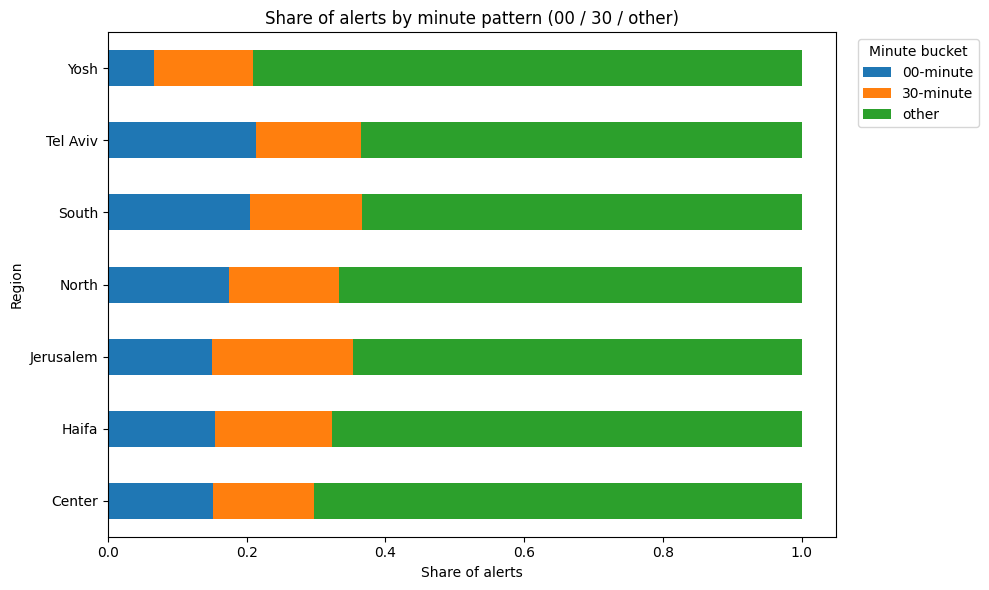

In [129]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_df.plot(kind="barh", stacked=True, ax=ax)

ax.set_title("Share of alerts by minute pattern (00 / 30 / other)")
ax.set_xlabel("Share of alerts")
ax.set_ylabel("Region")

ax.legend(title="Minute bucket", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

From first glance it may seem that there is no significance in alert time, however! The buckets were set with 5 minute variance each direction. Therefore:
2 buckets = 10 * 2 = 20 minutes. 20 minutes in each hour is 33% of whole day time. Eyeballing the graph, we can say that in all regions except Yosh, appr 32% of alerts
happen during 33% of time. In other words, every 3rd alert happens durin 00th minute or 30th minute. And other 2 - during the rest of time (XX:06 - XX:25 and XX:35-XX:55) which is more spread. Tel-Aviv area is visibly more threatened during the 00th miute, while Jerusalem area - during the 30th minute.

## Statistical hypothesis: are the minute-buckets distribution real or just random? (statistical uncertainty)

Confidence interval: CI=p±1.96⋅np(1−p)​ (here p is the share we got before and n is the total alerts in region)

In [130]:
# confidence intervals per region × bucket
region_totals = df.groupby("region").size().rename("n")

by_region_minute = by_region_minute.merge(region_totals, on="region")

by_region_minute["ci_low"] = by_region_minute["share"] - 1.96 * np.sqrt(
    (by_region_minute["share"] * (1 - by_region_minute["share"]))
    / by_region_minute["n"]
)

by_region_minute["ci_high"] = by_region_minute["share"] + 1.96 * np.sqrt(
    (by_region_minute["share"] * (1 - by_region_minute["share"]))
    / by_region_minute["n"]
)
by_region_minute.head()
# Narrow CI → strong evidence
# Wide CI → region has few alerts → don’t overinterpret

,region,minute_bucket,count,share,n,ci_low,ci_high
0,Center,00-minute,4622,0.15,30554,0.15,0.16
1,Center,30-minute,4463,0.15,30554,0.14,0.15
2,Center,other,21469,0.70,30554,0.70,0.71
3,Haifa,00-minute,525,0.16,3387,0.14,0.17
4,Haifa,30-minute,571,0.17,3387,0.16,0.18


CHi squared test: Are the alerts really more likely at 00 or 30 min or not? (other)
* (H₀): Minute buckets are uniformly distributed
* (H1): Minute buckets are distributed unevenly and YES they are more likely to happen at 00 / 30

In [131]:
observed = df["minute_bucket"].value_counts().sort_index()
chi2, p_value = chisquare(observed)
print(f"Chi2: {chi2:.10f}, p-value: {p_value:.50f}")
print(f"Chi2: {chi2:.10f}, p-value: {p_value:.5e}")
# p-value: 0.0e+00 - super tiny

Chi2: 53442.9478983889, p-value: 0.00000000000000000000000000000000000000000000000000
Chi2: 53442.9478983889, p-value: 0.00000e+00


Interpretation:
p < 0.001 → extremely strong evidence -> clustering is real

In [132]:
# per region
results = []

for region, g in df.groupby("region"):
    counts = g["minute_bucket"].value_counts()

    if len(counts) < 3:
        continue  # skip regions with missing buckets

    chi2, p = chisquare(counts)

    results.append({"region": region, "chi2": chi2, "p_value": p})

chi2_results = pd.DataFrame(results).sort_values("p_value")
chi2_results["p_value_sci"] = chi2_results["p_value"].apply(lambda x: f"{x:.5e}")
chi2_results

,region,chi2,p_value,p_value_sci
0,Center,"18,755.34",0.00,0.00000e+00
1,Haifa,"1,794.88",0.00,0.00000e+00
2,Jerusalem,"1,763.18",0.00,0.00000e+00
3,North,"17,084.26",0.00,0.00000e+00
4,South,"7,706.02",0.00,0.00000e+00
6,Yosh,"5,777.19",0.00,0.00000e+00
5,Tel Aviv,"1,368.81",0.00,5.85582e-298


* All regions have very small p-values which means there is a very strong timing structure = alerts are LESS random in time.
* Center, North, and South have very high chi-squared statistics => their minute distributions are very concentrated around minutes bucket groups that I defined (0 & 30min).

* Result: H0 rejected.
* Alert timestamps are not uniformly distributed within the hour.
* There is statistically significant clustering around 00 and 30 minutes, consistent across multiple regions.

## Geo distribution

In [133]:
by_region_zone = df.groupby(["region", "alert_zone"]).size().reset_index(name="count")
by_region_zone.head()

,region,alert_zone,count
0,Center,Ashdod,154
1,Center,Beit Shemesh,5
2,Center,Center Galilee,333
3,Center,Center Negev,27
4,Center,Confrontation Line,215


In [134]:
# Make sure by_region_zone exists and has all columns you need
# Example: by_region_zone = df.groupby(["region", "alert_zone"]).size().reset_index(name="count")

# Export to CSV
by_region_zone.to_csv("by_region_zone_export.csv", index=False, encoding="utf-8-sig")

print("Exported all rows to 'by_region_zone_export.csv'.")

Exported all rows to 'by_region_zone_export.csv'.


THe region was assigned as per locality. During the above cell analysis, I observed taht some regions are definitely not corresponding to the zone. Example:
* region	alert_zone
* Center	Center Galilee,
* Center	Gaza Containment,
* Jerusalem	South Golan,
* North	Dead Sea,
* North	South Negev,
* South	South Golan,

Manually changing all i.e. Center Gallillee to North may result in irrepairable mistake. After deeper analysis of regions VS zones and localities corresponding to those regions, I came to conclusion that the mistakes are due to the name duplication / translation of localities names. There are many mistakes however their share in the total count of rows is insignificant.

In [135]:
geo_sunburst = px.sunburst(
    by_region_zone,
    path=["region", "alert_zone"],
    values="count",
    color="count",
    color_continuous_scale="Viridis",
    width=1200,
    height=1000,
    title="Sunburst of Missions by year and country",
)

geo_sunburst.update_traces(
    sort=False, selector=dict(type="sunburst")
)

geo_sunburst.show()

## Largest cities: alerts count

In [136]:
largest_cities = [
    "Jerusalem",
    "Tel Aviv-Yafo",
    "Haifa",
    "Bnei Brak",
    "Ashdod",
    "Beersheba",
]

largest_cities_df = df[df["city"].isin(largest_cities)]
largest_cities_count = (
    largest_cities_df.groupby(["month_year", "city"])
    .size()
    .reset_index(name="count")
    .sort_values("month_year")
)

largest_cities_count

,month_year,city,count
0,2018-12,Bnei Brak,1
1,2018-12,Tel Aviv-Yafo,4
2,2019-02,Jerusalem,1
3,2019-03,Bnei Brak,2
4,2019-03,Tel Aviv-Yafo,6
...,...,...,...
89,2025-09,Ashdod,9
90,2025-09,Bnei Brak,4
91,2025-09,Jerusalem,22
92,2025-09,Tel Aviv-Yafo,19


In [137]:
## may need to run the cell twice, on first run get an error, just rerun

# Separating Ashdod due to its scale being far larger than other cities
ashdod_df = largest_cities_count[largest_cities_count["city"] == "Ashdod"]
other_cities_df = largest_cities_count[largest_cities_count["city"] != "Ashdod"]

# # Converting to timestamp like "2023-10" otherwise wont work as type of 'month_year' ='Period'
largest_cities_count["month_year_ts"] = largest_cities_count[
    "month_year"
].dt.to_timestamp()


large_cities_graph = go.Figure()

# Add all other cities to primary y-axis
for city in other_cities_df["city"].unique():
    city_df = other_cities_df[other_cities_df["city"] == city].sort_values(
        "month_year_ts"
    )
    large_cities_graph.add_trace(
        go.Scatter(
            x=city_df["month_year_ts"],
            y=city_df["count"],
            name=city,
            mode="lines+markers",
            yaxis="y1",
        )
    )

# Add Ashdod to secondary y-axis
ashdod_df = ashdod_df.sort_values("month_year_ts")
large_cities_graph.add_trace(
    go.Scatter(
        x=ashdod_df["month_year_ts"],
        y=ashdod_df["count"],
        name="Ashdod",
        mode="lines+markers",  # determines how the graph looks, mine - line plot with points
        yaxis="y2",
        line=dict(color="red", width=2, dash="dot"),
    )
)

# Layout
large_cities_graph.update_layout(
    title="Timeline of alert counts: Ashdod vs Other Largest Cities",
    xaxis=dict(title="Month", type="date"),
    yaxis=dict(title="Largest Cities Count, except Ashdod area (primary)", side="left"),
    yaxis2=dict(
        title="Ashdod area Count (secondary)",
        overlaying="y",
        side="right",
    ),
    height=600,
    legend=dict(
        orientation="h",  # horizontal legend
        yanchor="bottom",
        y=1.02,  # place above the plot
        xanchor="center",
        x=0.5,  # center it
    ),
)


large_cities_graph.show()

KeyError: 'month_year_ts'

## Analysis / conclusions
* North region received highest count of alerts during the analyzed period (Dec 26, 2018-Dec 27, 2025).
* Vast majority of Terrorist infiltrations took place in Yosh region.
* 21.2% of all alerts in the North are Unrecognized aircraft alerts (& Haifa area - 7.8%). Rest of areas it's below 3%.
* Ashdod high numbers are mostly due to the fact that the city covers vast areas around it, including many industrial parks and districts.
* When analyzing, city size must be taken into consideration, as the alerts shot on large area disturb much larger amount of people, while multiple attacks onto a small town means it's targeted due to some reason (location, probably).
* The worst days were seen in Ashdod and Ashkelon, with amount of alerts from 113 to 389 PER SINGLE DAY! Ashdod was targeted during all 3 peaks of the wars: NOv 2019, Oct 2023, Jun 2025. 389 alerts per day means alert each 3.7 minutes.
* Period-wise, it's more or less same, with slightly more alerts during the morning hours and over 23% of daily alerts during the nighttime. Most night alerts are sounded in the Center region. Among 20 top cities who received night alerts, 13.5% of them happened in Ashdod area and 9.6% in Tel-Aviv area.
* Most alerts sounded between 7 and 8 AM, 6 and 7 PM and 8 and 9 PM.
* June 2025 marked the highest count of alerts (almost 34K). However amount of rockets was not as high as any other period. It's due to the fact that the rockets used in June 2025 by Iran were ballistic (they have a very large and wide area of damage in case of hit, therefore alerts sounded in multiple zones simultaneously)
* There is very clear change in the period of alert from year to year: 2020 (only 20% of alerts happened during the morning and night). In 2023 most alerts happened in the morning, especially the morning of Oct 7 and only 5% at night. However in 2025 35% of alerts happened at night, which was strong psycological pressure on the population of most regions.
* Statistical research confirmed my hypothethis that large portion of alerts happened at specific time, as if the terrorists set a reminder alarm. Those times are around 00th minute and 30th minute.